# Accelerating MCMC Using Active Subspaces

##### Ryan Howard, Colorado School of Mines, <ryhoward@mines.edu>
##### Paul Constantine, Colorado School of Mines, <pconstan@mines.edu>
##### Carson Kent, Stanford University, <crkent@stanford.edu>
##### Tan Bui-thanh, University of Texas at Austin, <tanbui@ices.utexas.edu>


<br>

In this notebook, we'll be summarizing the active subspaces-based MCMC acceleration presented in [[1]][R1].

### Introduction

Markov Chain Monte Carlo (MCMC) is the primary computational tool used in Bayesian problems (especially inverse problems). The goal of MCMC is to create Markov Chains whose limiting distribution is the distribution you'd like to sample from (the posterior distribution of parameters, for example). Standard MCMC is inefficient when the parameter space is high-dimensional or evaluating the likelihood is expensive; exhaustively exploring high-dimensional spaces to find high-likelihood regions or evaluating many expensive likelihoods (from forward models that rely on PDE approximations, for example) can make MCMC prohibitively expensive.

One approach to decreasing the cost of MCMC is to perform it on a low-dimensional subspace of the parameter space. Here we'll achieve this goal by looking for an _active subspace_ based on the negative log-likelihood of the data and the prior distribution of the parameters. If we can find such a subspace, we can construct a function that approximates the posterior distribution in fewer dimensions, increasing the efficiency of the resulting MCMC. Since the active subspace does not depend on the posterior, it can be computed before doing MCMC as a preprocessing step, which is computationally appealing.

### Active Subspaces

Consider a scalar-valued, differentiable function $f(\mathbf x)$ from $R^m$ into $R$ and let $\rho(\mathbf x)$ be a pdf on $\mathbf x$ such that

$$
\int \mathbf x\ \rho\ d\mathbf x = 0,\ \ \ \int\mathbf x\ \mathbf x^T\ \rho\ d\mathbf x = \mathbf I,
$$

where $\mathbf I$ is the $m\times m$ identity matrix. Active subspace methodololgy is based on the matrix

$$
\mathbf C = \int\nabla f\nabla f^T\ \rho\ d\mathbf x = \mathbf W\Lambda\mathbf W^T,
$$

where $\mathbf W$ is the matrix of eigenvectors and $\Lambda$ is the diagonal matrix of eigenvalues in descending order. The $i^{th}$ eigenvalue quantifies the change of $f$ along the $i^{th}$ eigenvector: $\int(\mathbf w_i^T\ \nabla f)^2\rho\ d\mathbf x = \lambda_i$; if $\lambda_i$ is small, $f$ tends to be relatively constant along $\mathbf w_i$. To define the active subspace, we partition the eigendecomposition as:

$$
\mathbf W = \left[\begin{matrix}\mathbf W_1 & \mathbf W_2\end{matrix}\right],\ \ \Lambda = \left[\begin{matrix}\Lambda_1 & \\ & \Lambda_2\end{matrix}\right],
$$

where $\mathbf W_1$ contains the first $n$ (out of $m$) eigenvectors and $\Lambda_1$ has the first $n$ eigenvalues (this partition will be work if $\lambda_n > \lambda_{n+1}$). The active subspace is the span of $\mathbf W_1$'s columns; perturbations along these directions tend to change $f$ more than in the orthogonal directions. For any $\mathbf x\in R^m,\ \mathbf x = \mathbf W\mathbf W^T\mathbf x = \mathbf W_1 \mathbf W_1^T \mathbf x + \mathbf W_2\mathbf W_2^T\mathbf x = \mathbf W_1\mathbf y + \mathbf W_2 \mathbf z$. $\mathbf y = \mathbf W_1^T\mathbf x$ are called the active variables and $\mathbf z = \mathbf W_2^T\mathbf x$ the inactive variables. The distribution $\rho(\mathbf x)$ can be written as a joint density of $\mathbf y$ and $\mathbf z$: $\rho(\mathbf x) = \rho(\mathbf W_1\mathbf y + \mathbf W_2 \mathbf z) = \rho(\mathbf y, \mathbf z)$ (if $\rho$ is standard Gaussian, marginal and conditional densities of $\mathbf y$ and $\mathbf z$ will also be standard Gaussian).

If $\lambda_{n+1},\dots,\lambda_m$ are small, we can approximate $f$ as

$$
f(\mathbf x)\approx g(\mathbf y) = \int f(\mathbf W_1\mathbf y + \mathbf W_2\mathbf z)\ \rho(\mathbf z|\mathbf y)\ d\mathbf z.
$$

$g$ is the conditional average of $f$ given $y$; if $f$ is relatively constant in $\mathbf z$, we expect this to be a good approximation. The RMSE of this approximation is bounded by 

$$
\left(\int\left(f(\mathbf x) - g(\mathbf W_1^T\mathbf x)\right)^2\ \rho\ d\mathbf x\right)^{1/2} \leq C(\lambda_{n+1} + \cdots + \lambda_m)^{1/2},
$$

where $C$ is the Poincare constant associated with $\rho$ ($C$ = 1 if $\rho$ is standard Gaussian). $g$ is difficult to compute, so we can use simple Monte Carlo integration to approximate it:

$$
g(\mathbf y) \approx \hat g(\mathbf y) = \frac 1 M\sum_{i=1}^M f(\mathbf W_1\mathbf y + \mathbf W_2\mathbf z_i),
$$

where $\{\mathbf z_i\}_{i=1}^M$ are drawn independently from $\rho(\mathbf z|\mathbf y)$. The error bound on the resulting approximation is

$$
\left(\int\left(f(\mathbf x) - \hat g(\mathbf W_1^T\mathbf x)\right)^2\ \rho\ d\mathbf x\right)^{1/2} \leq C(1 + M^{-1/2})(\lambda_{n+1} + \cdots + \lambda_m)^{1/2}.
$$

Of course we can't generally compute the matrix $\mathbf C$ analytically, so we approximate it with simple Monte Carlo: draw $\{\mathbf x_i\}_{i=1}^N$ from $\rho$ and compute $\nabla f(\mathbf x_i)$ for each $i$, then

$$
\mathbf C\approx \hat{\mathbf C} = \frac 1 N\sum_{i=1}^N \nabla f(\mathbf x_i)\ \nabla f(\mathbf x_i)^T = \hat{\mathbf W}\hat\Lambda\hat{\mathbf W}^T.
$$

The estimated active and inactive variables are $\hat{\mathbf y} = \hat{\mathbf W}_1^T\mathbf x$ and $\hat{\mathbf z} = \hat{\mathbf W}_2^T\mathbf x$, respectively. The error in the estimated subspace, $\epsilon = ||\hat{\mathbf W}_1^T\mathbf W_2||$ is inversely proportional to $\lambda_{n} - \lambda_{n+1}$, and we can define our approximation as

$$
f(\mathbf x) \approx g_\epsilon(\hat{\mathbf W}_1^T\mathbf x) = \int f(\hat{\mathbf W}_1\hat{\mathbf y} + \hat{\mathbf W}_2\hat{\mathbf z}) \rho(\hat{\mathbf z}|\hat{\mathbf y})d\hat{\mathbf z}
$$

with error bound

$$
\left(\int\left(f(\mathbf x) - g_\epsilon(\hat{\mathbf W}_1^T\mathbf x)\right)^2\ \rho\ d\mathbf x\right)^{1/2} \leq C\left(\epsilon(\lambda_{1} + \cdots + \lambda_n)^{1/2} + (\lambda_{n+1} + \cdots + \lambda_m)^{1/2}\right).
$$

We can approximate $g_\epsilon$ using simple Monte Carlo in the same way we approximate $g$:

$$
g_\epsilon(\hat{\mathbf y})\approx \hat{g}_\epsilon(\hat{\mathbf y}) = \frac 1 M\sum_{i=1}^M f(\hat{\mathbf W}_1\hat{\mathbf y} + \hat{\mathbf W}_2\hat{\mathbf z}_i),
$$

which has error bound

$$
\left(\int\left(f(\mathbf x) - \hat g_\epsilon(\hat{\mathbf W}_1^T\mathbf x)\right)^2\ \rho\ d\mathbf x\right)^{1/2} \leq C(1+M^{-1/2})\left(\epsilon(\lambda_{1} + \cdots + \lambda_n)^{1/2} + (\lambda_{n+1} + \cdots + \lambda_m)^{1/2}\right).
$$

In summary, we have a function, $f$, that we'd like to approximate, and we do this in 4 layers: a low-dimensional conditional average, $g(\mathbf y)$; an approximated conditional average, $\hat g(\mathbf y)$; a conditional average using estimated eigenvectors, $g_\epsilon(\hat{\mathbf y})$; and an approximated conditional average using estimated eigenvectors, $\hat g_\epsilon(\hat{\mathbf y})$. $\hat g_\epsilon$ will be used in the majority of cases since the others rely on knowing non-approximated values of quantities that are nearly impossible to derive analytically.

### Estimating a Bayesian Posterior

Consider the Bayesian inverse problem involving an additive noise model: $\mathbf d = \mathbf m(\mathbf x) + \mathbf e$, where $\mathbf d$ are the observed data, $\mathbf x$ are the parameters, $\mathbf m$ is a deterministic map (the forward model), and $\mathbf e$ is the noise. Assume $\mathbf m$ is differentiable and $\mathbf e \sim N(\mathbf 0, \sigma^2\mathbf I)$. Then the likelihood function is 

$$
\rho_{\text{lik}}(\mathbf d,\ \mathbf x) = \exp\left(\frac{-||\mathbf d - \mathbf m(\mathbf x)||^2}{2\sigma^2}\right)
$$

and by Bayes' Theorem,

$$
\rho_{\text{pos}}(\mathbf x) = c_{\text{pos}}^{-1}\ \rho_{\text{lik}}(\mathbf d,\ \mathbf x)\ \rho_{\text{pri}}(\mathbf x),\ \ \ c_{\text{pos}}^{-1} = \int\rho_{\text{lik}}(\mathbf d,\ \mathbf x)\ \rho_{\text{pri}}(\mathbf x)\ d\mathbf x.
$$

To identify the active subspace, we choose $f$ to be the negative log-likelihood: $f(\mathbf x) = \frac{1}{2\sigma^2}||\mathbf d - \mathbf m(\mathbf x)||^2$, and $\rho$ to be the prior likelihood of $\mathbf x$: $\rho(\mathbf x) = \rho_{\text{pri}}(\mathbf x)$. Then we an construct an approximation of the posterior as

$$
\rho_{\text{pos}}(\mathbf x)\approx \pi(\mathbf x) = c_\pi^{-1}\exp(-g(\mathbf y))\rho_{\text{pri}}(\mathbf y)\rho_{\text{pri}}(\mathbf z|\mathbf y),\ \ c_\pi^{-1} = \int\exp(-g(\mathbf W_1^T\mathbf x))\rho_{\text{pri}}(\mathbf x)\ d\mathbf x.
$$

We can substitute $\hat g, g_\epsilon,$ and $\hat g_\epsilon$ for $g$ above to get $\hat\pi, \pi_\epsilon$, and $\hat\pi_\epsilon$. The Hellinger distance between the true posterior and these $\pi$'s has the same formula as the error bounds on $g, \hat g, g_\epsilon$, and $\hat g_\epsilon$, replacing $C$ with $L$, where

$$
L^2 = \frac 1 8\left[\left(\int\exp(-f)\rho_{\text{pri}}d\mathbf x\right)\left(\exp\left(-\int f\rho_{\text{pri}}d\mathbf x\right)\right)\right]^{-1/2}.
$$

For example, $H(\rho_{\text{pos}},\hat\pi_\epsilon) \leq L(1+M^{-1/2})\left(\epsilon(\lambda_1 + \cdots + \lambda_n)^{1/2} + (\lambda_{n+1} + \cdots + \lambda_m)^{1/2}\right)$.

### Applying Active Subspaces to MCMC

The first step in applying active subspaces to MCMC is to compute the active subspace using Monte Carlo, as described above, gaining estimates for $\mathbf W_1$ and $\Lambda$. If there is a large gap in the eigenvalues and small values after this gap, there may be an exploitable low-dimensional subspace. If these conditions are present, we can apply the following MCMC algorithm:

1. Pick an initial value, $\hat{\mathbf y}_1$ and compute $\hat g_\epsilon(\hat{\mathbf y}_1)$. Set $k = 1$.
2. Draw $\hat{\mathbf y}'$ from a symmetric proposal distribution centered at $\hat{\mathbf y}_k$.
3. Compute $\hat g_\epsilon(\hat{\mathbf y}')$.
4. Compute the acceptance ratio $\gamma =  \min\left(1, \frac{\exp(-\hat g_\epsilon(\hat{\mathbf y}'))\rho_{\text{pri}}(\hat{\mathbf y}')}{\exp(-\hat g_\epsilon(\hat{\mathbf y}_k))\rho_{\text{pri}}(\hat{\mathbf y}_k)}\right)$.
5. Draw $t$ from a Unif(0, 1) distribution.
6. If $t \leq \gamma$, set $\hat{\mathbf y}_{k+1} = \hat{\mathbf y}'$, otherwise set $\hat{\mathbf y}_{k+1} = \hat{\mathbf y}_k$.
7. Increment $k$ and repeat from step 2.

This algorithm is performing Metropolis-Hastings on the estimated active variables $\hat{\mathbf y}$. Step 3 requires $M$ forward model evaluations by our Monte Carlo setup, whereas standard MH only requires 1 evaluation. While this tends to increase the number of forward model evaluations by a factor of $M$, the exponential nature of dimension growth can make dimension reduction through active subspaces plenty worthwhile. To transform the resulting set $\{\hat{\mathbf y}_k\}$ to the original input space, for each $k$, draw $\{\hat{\mathbf z}_{k,l}\}_{l=1}^P$ from $\rho_{\text{pri}}(\hat{\mathbf z}|\hat{\mathbf y}_k)$ and compute $\mathbf x_{k,l} = \hat{\mathbf W}_1\hat{\mathbf y}_k + \hat{\mathbf W}_2\hat{\mathbf z}_{k,l}$. This does not require any forward model evaluations and we expect lower correlation among the $\mathbf x_{k,l}$ compared to standard MCMC since the $\hat{\mathbf z}$'s are drawn independently.

### References:

[[1]][R1] Accelerating MCMC with Active Subspaces

[[2]][R2] Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces, _Siam Journal of Scientific Computing_

[R1]: https://arxiv.org/abs/1510.00024
[R2]: http://dx.doi.org/10.1137/130916138

<br>

### Demonstrations

We'll now demonstrate active-subspaces accelerated MCMC on two examples from [[1]][R1] using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces).

The first example is a two-parameter quadratic model: $\mathbf x = [x_1,\ x_2]^T$,

$$
\mathbf m(\mathbf x) = \frac 1 2\mathbf x^T\mathbf A\mathbf x,\ \ \ \mathbf A = \mathbf Q\left[\begin{matrix}1 & \\ & \epsilon\end{matrix}\right]\mathbf Q^T,\ \ \ \mathbf Q = \frac 1 2\left[\begin{matrix}\sqrt 2 & \sqrt 2 \\ -\sqrt 2 & \sqrt 2\end{matrix}\right].
$$

We use $\epsilon = .01$ ($\mathbf m(\mathbf x)$ with $\epsilon$ close to 1 don't have active subspaces), noise parameter in the likelihood of $\sigma = .1$, and we assume our single data point is $\mathbf d = .9$.

In [6]:
%matplotlib inline
import numpy as np
import active_subspaces as ac
import matplotlib.pyplot as plt

First we set up the relevant functions.

In [2]:
Q = .5*np.array([[np.sqrt(2), np.sqrt(2)], [-np.sqrt(2), np.sqrt(2)]])
eps = .01
A = Q.dot(np.array([[1, 0], [0, eps]])).dot(Q.T)

#The forward model and its gradient
def m(x):
    if len(x.shape) == 1: x = np.atleast_2d(x).T
    B = .5*x.T.dot(A).dot(x)
    if B.shape != (1, 1): return np.atleast_2d(np.diag(B)).T
    else: return B
def dm(x):
    return A.dot(x)

#data
d = np.array([.9])
#likelihood std dev
sigma = .1
#likelihood and its gradient
def f(x):
    return (d - m(x))**2/(2.*sigma**2)
def df(x):
    return 1./sigma**2*dm(x)*(d - m(x).T)

We approximate the subspace by Monte Carlo.

In [3]:
#Number of MC points
M = 1000

#sample x according to its prior (standard Gaussian), compute f and its gradient
x = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), (M,)).T
grad = df(x).T
output = f(x)

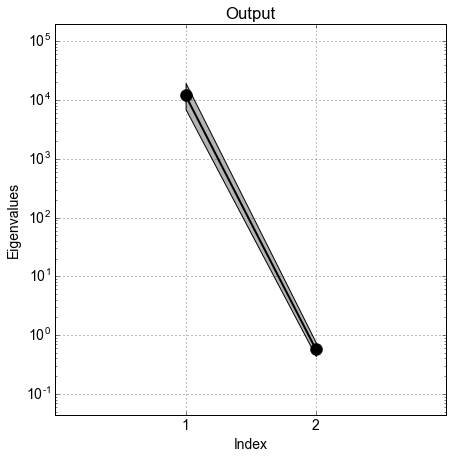

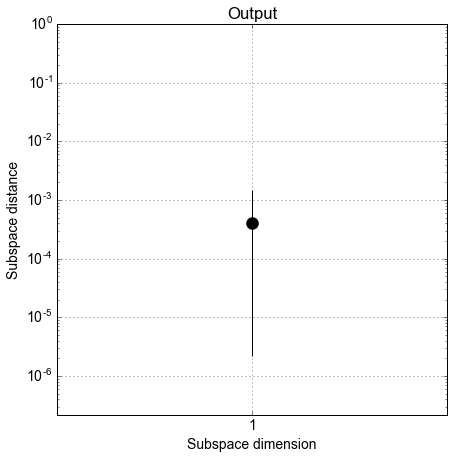

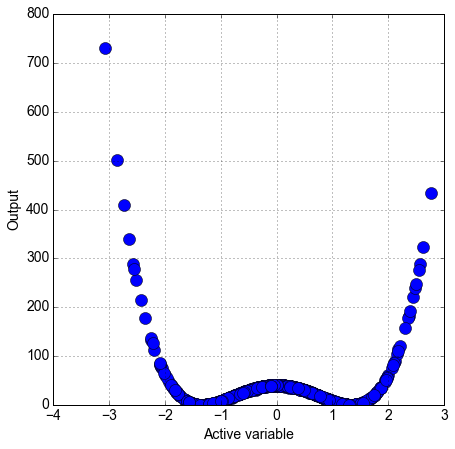

In [4]:
#Subspace object
ss = ac.subspaces.Subspaces()
#This computes W and \Lambda using our gradient samples and bootstraps for eigenvalues and 
#subspace errors
ss.compute(df=grad, nboot=500)

#Plot eigenvalues, subspace error, and a sufficient summary plot (output vs. active variable)
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(x.T.dot(ss.W1), output)

We can see a large gap in the eigenvalues and a small estimated subspace error, indicating the presence of an active subspace. This is confirmed by the tight trend in the sufficient summary plot.

We now perform standard MCMC on $\mathbf x$ using a Metropolis-Hastings algorith with a normal proposal centered at the previous replicate and covariance $.5\mathbf I$. For $10^6$ samples, this can take several minutes to run.

In [5]:
#Standard MH MCMC

#Sampling order of magnitude, e.g. O = 6 => 10^6 MCMC replicates
O = 6
#Number of MCMC replicates
M = 10**O
#array of MCMC replicates, x_1 in row 1, x_2 in row 2
x_MCMC = np.empty((2, M))
#initial guess
x_MCMC[:,0] = np.array([1, 1])
#Prior distribution of x (standard Gaussian) (normalizing constant is left off since it 
#would cancel in the acceptance ratio anyway)
rho_pri = lambda x: np.exp(-.5*x.T.dot(x))
#For calculating the acceptance ratio
N_accept = 0

#Metropolis-Hastings MCMC
for i in range(1, M):
    #proposal value
    xprime = np.random.multivariate_normal(x_MCMC[:,i-1], .5*np.array([[1, 0], [0, 1]]))
    #Acceptance Ratio
    gamma = (np.exp(-f(xprime))*rho_pri(xprime))/\
        (np.exp(-f(x_MCMC[:,i-1]))*rho_pri(x_MCMC[:,i-1]))
    
    if np.random.uniform() <= gamma: x_MCMC[:, i] = xprime; N_accept += 1
    else: x_MCMC[:, i] = x_MCMC[:,i-1]
        
print "The acceptance ratio is {:.4}".format(1.*N_accept/M)

The acceptance ratio is 0.1193


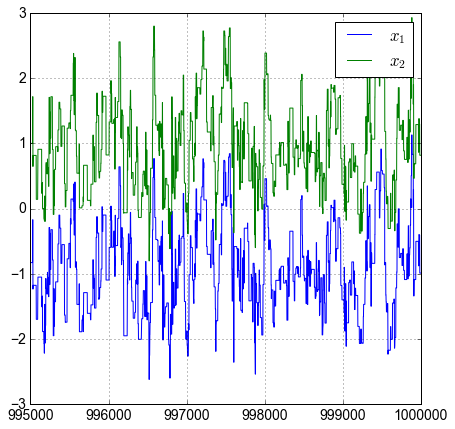

In [6]:
#Make trace plots of the last several thousand replicates
plt.figure(figsize=(7,7))
plt.plot(np.arange(M - 5000, M), x_MCMC[0,-5000:],np.arange(M - 5000, M), x_MCMC[1,-5000:])
plt.grid(True)
plt.legend([r'$x_1$', r'$x_2$'])

We can see significant autocorrelation and cross-correlation in these samples.

Now we perform Metropolis-Hastings MCMC on the active variable using one order of magnitude fewer samples than for vanilla MCMC. For each sampled $\mathbf y$, we will sample 10 $\mathbf z$'s according to $\rho(\mathbf z|\mathbf y)$ and compute the conditional average of $f$ given $\mathbf y$ with Monte Carlo, so the total number of forward model evaluations is the same as with vanilla MCMC.

In [7]:
#Number of MCMC replicates for y
M = 10**(O - 1)

y_MCMCAS = np.empty((1, M))
y_MCMCAS[:,0] = np.array([1])

rho_pri = lambda x: np.exp(-.5*x.T.dot(x))

N_accept = 0

#approximate conditional average of f given y by samplig z according to p(z|y)
def g(y):
    N = 10
    f_evals = np.empty(N)
    z = np.random.normal(size=(1, N))
    return f(ss.W1*y + ss.W2*z).mean()

#MH MCMC on the active variable
for i in range(1, M):
    yprime = np.array(np.random.normal(y_MCMCAS[:, i-1], np.sqrt(.5)))
    gamma = (np.exp(-g(yprime))*rho_pri(yprime))/\
        (np.exp(-g(y_MCMCAS[:,i-1]))*rho_pri(y_MCMCAS[:,i-1]))
    if np.random.uniform() <= gamma: y_MCMCAS[:, i] = yprime; N_accept += 1
    else: y_MCMCAS[:, i] = y_MCMCAS[:,i-1]
        
print "The acceptance ratio is {:.4}".format(1.*N_accept/M)

The acceptance ratio is 0.1346


For each $\mathbf y$ in our chain, we sample 10 $\mathbf z$'s and compute $\mathbf x = \mathbf W_1\mathbf y + \mathbf W_2 \mathbf z$, giving us an MCMC chain for $\mathbf x$.

In [8]:
x_MCMCAS = np.empty((2, M*10))
for i in range(M):
    z = np.random.normal(size=(1, 10))
    x_MCMCAS[:,i*10:(i+1)*10] = ss.W1*y_MCMCAS[:,i] + ss.W2*z

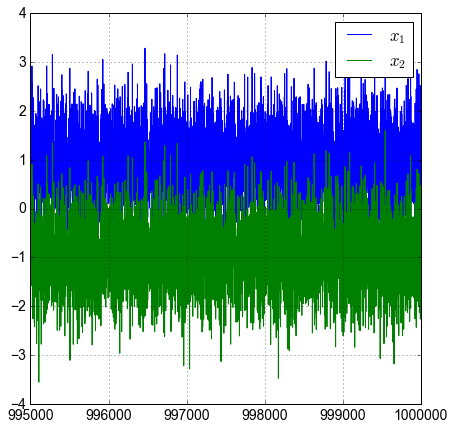

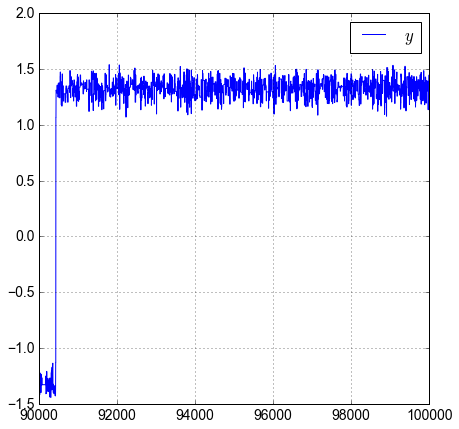

In [9]:
#make trace plots of the last several thousand replicates of x and y
M = 10**O

plt.figure(figsize=(7, 7))
plt.plot(np.arange(M - 5000, M), x_MCMCAS[0,-5000:],\
         np.arange(M - 5000, M), x_MCMCAS[1,-5000:])
plt.grid(True)
plt.legend([r'$x_1$', r'$x_2$'])

plt.figure(figsize=(7, 7))
plt.plot(np.arange(M/10 - 10000, M/10), y_MCMCAS[0,-10000:])
plt.grid(True)
plt.legend([r'$y$'])

There is much less correlation involved in the samples of $\mathbf x$ compared to vanilla MCMC because the $\mathbf z$'s are sampled independently. We have achieved a much better chain on $\mathbf x$ for the same number of forward model evaluations by using the active subspace.

We'll now show kernel density estimates for both MCMC methods on $\mathbf x$ and for $\mathbf y$ with the active subspace method. The KDE only uses $\sim 10^5$ samples because more would be too time-consuming (it already takes several minutes to run; increasing the number of points by a factor of 10 would result in runtimes of about 30 minutes).

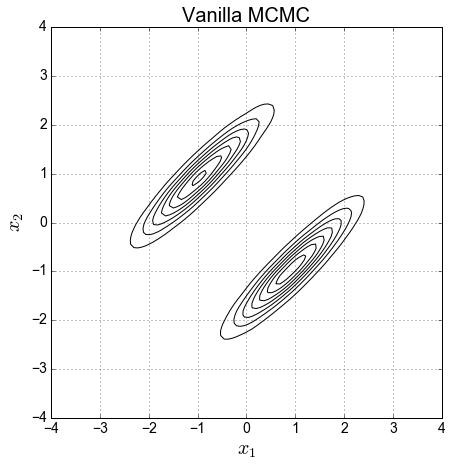

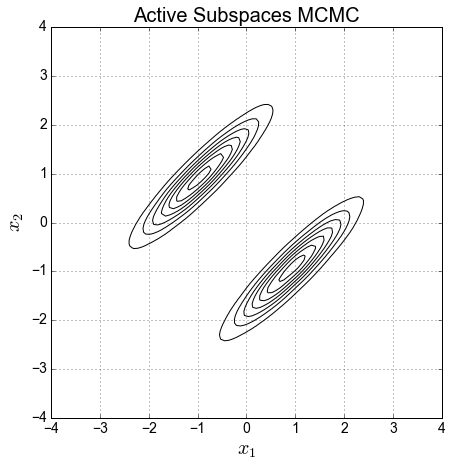

In [10]:
import scipy.stats as st

xmin, xmax = -4, 4
ymin, ymax = -4, 4

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

kernel = st.gaussian_kde(x_MCMC[:,np.random.choice(np.arange(M), 10**5, False)])
kernelAS = st.gaussian_kde(x_MCMCAS[:,np.random.choice(np.arange(M), 10**5, False)])

density = np.reshape(kernel(positions).T, xx.shape)
densityAS = np.reshape(kernelAS(positions).T, xx.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cset = ax.contour(xx, yy, density, colors='k')
plt.grid(True); plt.xlabel(r'$x_1$', fontsize=20); plt.ylabel(r'$x_2$', fontsize=20)
plt.title('Vanilla MCMC', fontsize=20)

fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cset = ax.contour(xx, yy, densityAS, colors='k')
plt.grid(True); plt.xlabel(r'$x_1$', fontsize=20); plt.ylabel(r'$x_2$', fontsize=20)
plt.title('Active Subspaces MCMC', fontsize=20)

plt.show()

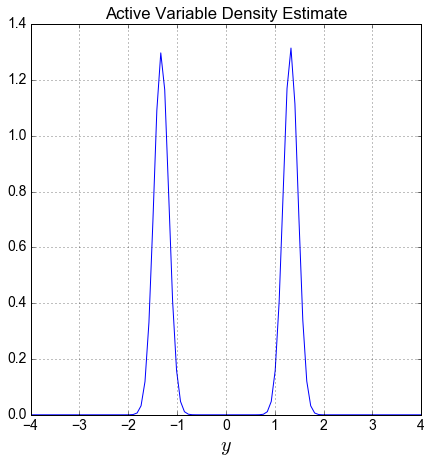

In [11]:
kernelY = st.gaussian_kde(y_MCMCAS)

x = np.linspace(-4, 4, 100)

plt.figure(figsize=(7, 7))
plt.plot(x, kernelY(x))
plt.grid(True); plt.xlabel(r'$y$', fontsize=20); plt.title('Active Variable Density Estimate')

The second exmaple we discuss is a PDE forward model. The PDE is

$$
-\nabla_{\mathbf s}\cdot(a(\mathbf s, \mathbf x)\nabla_{\mathbf s}u) = 1,
$$

where $u$ is the solution, $\mathbf s$ are the spatial coordinates, and $\mathbf x$ are 100 parameters characterizing the scalar field $a$. Our data are several (noisy) observations of $u$ on a few points of the nontrivial boundary of the problem geometry. The forward model, $\mathbf m(\mathbf x)$, takes the parameters $\mathbf x$ into the expected observed values at these points. To demonstrate the active subspace MCMC, we generate synthetic data by drawing a true value of $\mathbf x$ according to its prior (standard Gaussian), finding the PDE solution at the points we are intersted in, and perturbing these solution values with random noise. We demonstrate this process below, generating synthetic data, performing vanilla MCMC, estimating the active subspace, and performing active subspace MCMC. The code we use relies on Qiqi Wang's [Numpad](https://github.com/qiqi/numpad) package for computation. If you're running this notebook yourself, keep in mind that it can take about 10 minutes for this code to run per 1000 forward model evaluations; this is why we only use 1000 replicates for the vanilla and active-subspace chains.

In [2]:
from pde_mcmc_study import *
import pde_model as pdem

# instantiate the PDE model
model = pdem.PDESolver()
m = model.m

# generate synthetic observations for the inverse problem
x_true = np.random.normal(size=(m, 1))
obs = model.observations(x_true)

# perturb observations by noise for synthetic data
sig2 = 0.0001*np.linalg.norm(obs)**2
data = obs + np.sqrt(sig2)*np.random.normal(size=obs.shape)
model.set_data(data, sig2)

In [13]:
#Perform vanilla MCMC on the full 100-dimensional input space

N_van = 1000 #Number of MCMC replicates on full space
prop_sig = .1 #Proposal standard deviation
y0 = np.random.normal(size=(m, 1)) #MCMC starting point

# initialize data arrays
X_van = np.zeros((N_van, m))
accept_van = np.zeros((N_van, 1))

for i in range(N_van):
    # compute the approximate misfit
    mf = model.misfit(y0)
    
    # store misfits and chains
    X_van[i,:] = y0.reshape((m,))
    
    # proposal step in the active variables
    yc = y0 + np.random.normal(scale=prop_sig, size=y0.shape)
    
    # compute log of the acceptance ratio
    gamma = (mf - model.misfit(yc)) + 0.5*(np.dot(y0.T, y0) - np.dot(yc.T, yc))
    
    # compute the acceptance ratio
    alpha = np.minimum(1.0, np.exp(gamma))
    
    # accept / reject
    t = np.random.uniform(0.0, 1.0)
    if alpha > t:
        y0 = yc
        accept_van[i] = 1.0

print 'The acceptance ratio is {:.4}'.format(accept_van.mean())

The acceptance ratio is 0.541


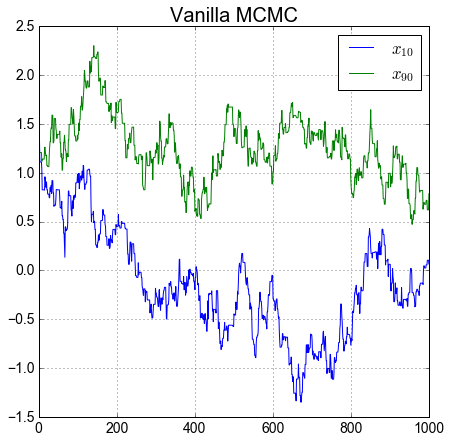

In [14]:
#Trace plot for the 10th and 90th components of x for demonstration
TP_N = 1000 #number of points to show in trace plot
plt.figure(figsize=(7, 7))
plt.plot(np.arange(N_van - TP_N, N_van), X_van[-TP_N:,9])
plt.plot(np.arange(N_van - TP_N, N_van), X_van[-TP_N:,89])
plt.grid(True)
plt.title('Vanilla MCMC', fontsize=20)
plt.legend([r'$x_{10}$', r'$x_{90}$'])

Similar to the quadratic forward model, we see significant autocorrelation in the components of $\mathbf x$ when performing MCMC on the full input space; it would take an inordinate amount of samples to achieve good estimates of the posterior density, which is prohibitively expensive in this case.

In [15]:
# compute the active subspace for the model's misfit given data
N_est = 1000 #Number of random points to sample for subspace estimation
ss = compute_misfit_active_subspace(N_est, model)

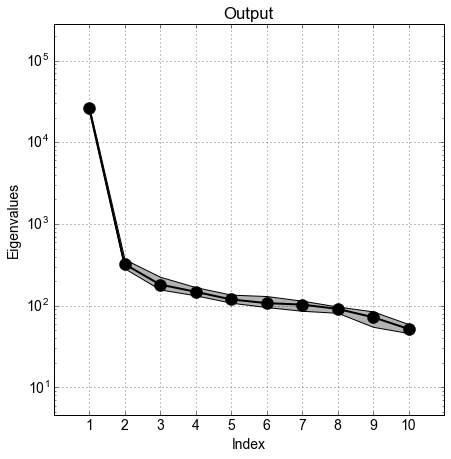

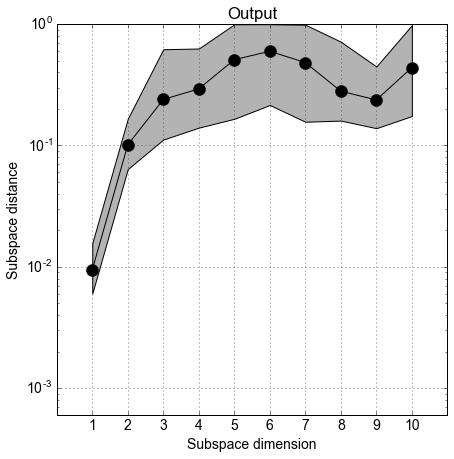

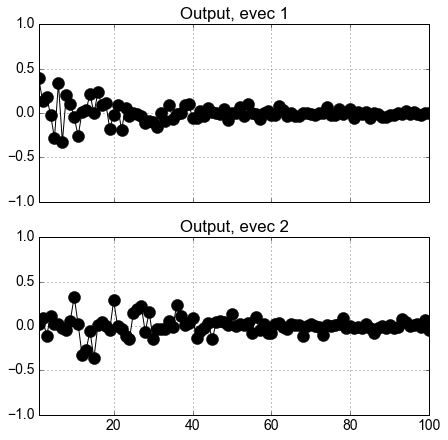

In [16]:
# set active subspace dimension to 2
n = 2
ss.partition(n)

# plot active subspace metrics
ac.utils.plotters.eigenvalues(ss.eigenvals[:10, 0], e_br=ss.e_br[:10,:])
ac.utils.plotters.subspace_errors(ss.sub_br[:10,:])
ac.utils.plotters.eigenvectors(ss.eigenvecs[:,:2])

We find significant gaps between the 1$^{st}$ and 2$^{nd}$ and between the 2$^{nd}$ and 3$^{rd}$ eigenvalues, and low subspace error associated with these dimensions, indicating 1- and 2-dimensional subspaces. We choose to use a 2-dimensional subspace for dimension reduction. The eigenvectors can be used as a measure of global sensitivity; higher-magnitude components indicate relative sensitivity to the corresponding input. The 100 inputs we have don't have much physical meaning by themselves, but we can examine sensitivity by looking at the coefficients, $a(\mathbf s, \mathbf x)$, with $\mathbf x$ as one of the eigenvectors. We plot these below.

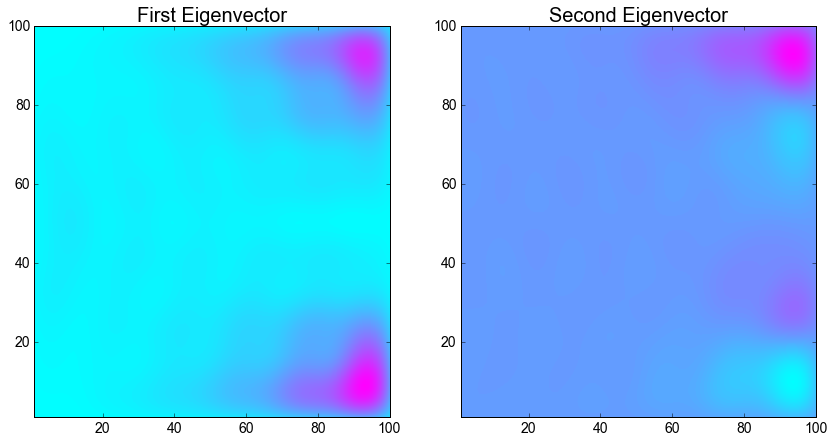

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7)); axes = axes.reshape(2).squeeze()

a = np.exp(model.B.dot(ss.W1[:,0][:,None]).reshape((model.nx, model.nx)))
x, y = np.arange(1, 101), np.arange(1, 101)
x, y = np.meshgrid(x, y)
axes[0].contourf(x, y, a, 100, cmap=plt.get_cmap('cool'))
axes[0].set_title('First Eigenvector', fontsize=20)

a = np.exp(model.B.dot(ss.W1[:,1][:,None]).reshape((model.nx, model.nx)))
axes[1].contourf(x, y, a, 100, cmap=plt.get_cmap('cool'))
axes[1].set_title('Second Eigenvector', fontsize=20)

As we might have conjectured, the output is most sensitive to changes in the coefficients near the right boundary (the nontrivial boundary on which our observations lie).

We now perform active subspaces MCMC as with the quadratic model and generate chains on $\mathbf x$ from our MCMC of $\mathbf y$.

In [18]:
# instantiate an active subspace accelerated MCMC sampler
asamcmc = ActiveSubspaceAcceleratedMCMC(model, ss)

# sample the active variables with MCMC
y0 = np.random.normal(size=(n, 1))
N_AS = 100 #Number of active variable MCMC replicates
M = 10 #Number of points to estimate E(f|y)
Y, MF, accept = asamcmc.sample_active_variables(y0, N_AS, M)
print 'Active subspace sampled, acceptance ratio: {:04.4f}'.format(np.mean(accept))

# sample inactive variables from prior and transform to original variables
P = 10 #Number of z samples for each y
X_AS = asamcmc.sample_original_variables(Y, P)

Active subspace sampled, acceptance ratio: 0.4700


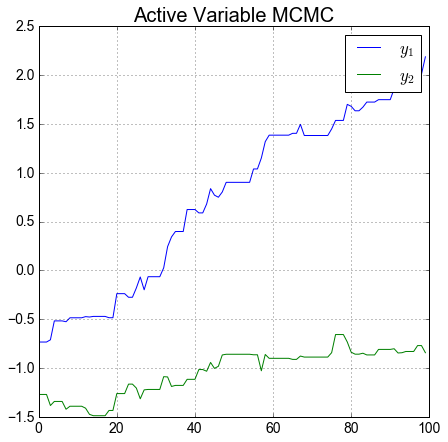

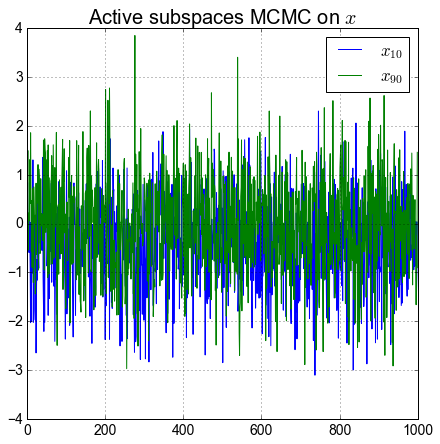

In [19]:
#Trace plot for the active variable
TP_N = 100 #number of points to show in trace plot
plt.figure(figsize=(7, 7))
plt.plot(np.arange(N_AS - TP_N, N_AS), Y[-TP_N:,0])
plt.plot(np.arange(N_AS - TP_N, N_AS), Y[-TP_N:,1])
plt.grid(True)
plt.title('Active Variable MCMC', fontsize=20)
plt.legend([r'$y_1$', r'$y_2$'])

#Trace plot for the 10th and 90th components of x
TP_N = 1000 #number of points to show in trace plot
plt.figure(figsize=(7, 7))
plt.plot(np.arange(N_AS*P - TP_N, N_AS*P), X_AS[-TP_N:,9])
plt.plot(np.arange(N_AS*P - TP_N, N_AS*P), X_AS[-TP_N:,89])
plt.grid(True)
plt.title(r'Active subspaces MCMC on $x$', fontsize=20)
plt.legend([r'$x_{10}$', r'$x_{90}$'])

Similar to the quadratic model, we observe significant autocorrelation in the vanilla case and little correlation when using the active subspace.

To validate our MCMC chains, we consider the variables $\hat{\mathbf y}_k = \hat{\mathbf W}^T\mathbf x_k$, where $\mathbf x_k$ are the replicates from the vanilla 100-dimensional MCMC chain. If our method is valid, we expect to see the posterior bivariate marginal distributions of the first 2 or so components of $\mathbf y$ to diverge from standard Gaussian (as they are updated by the data) while the other components remain standard Gaussian. We now construct and plot kernel density estimates to see if this is the case.

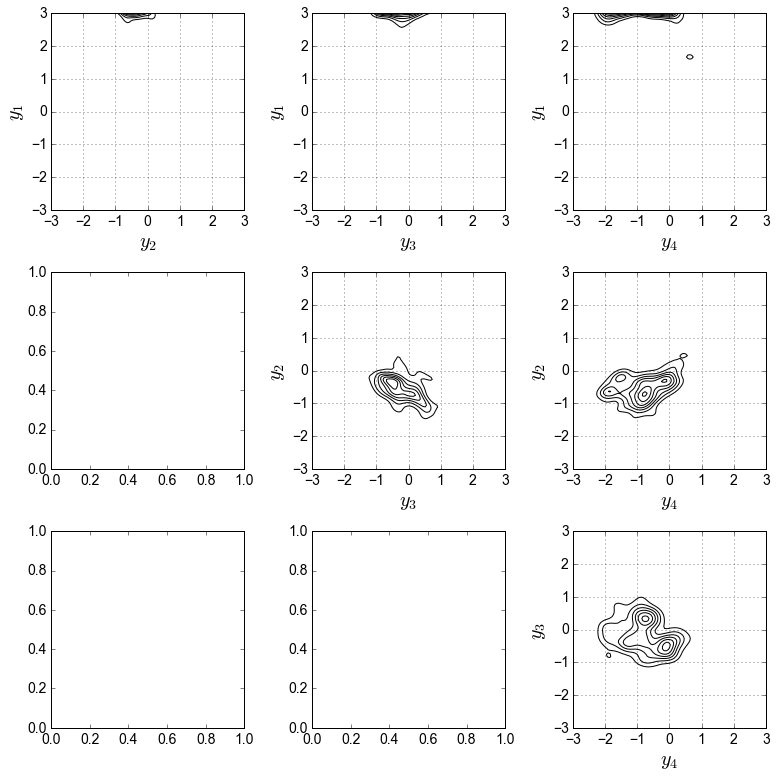

In [20]:
y = ss.eigenvecs.T.dot(X_van.T)

fig, axes = plt.subplots(3, 3, figsize=(11, 11)); axes = axes.reshape(9).squeeze()

xmin, xmax = -3, 3
ymin, ymax = -3, 3

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

plots = [0, 1, 2, 4, 5, 8]
masks = [[1, 0], [2, 0], [3, 0], [2, 1], [3, 1], [3, 2]]

for i in range(6):
    kernel = st.gaussian_kde(y[masks[i]])
    density = np.reshape(kernel(positions).T, xx.shape)
    
    axes[plots[i]].set_xlim(xmin, xmax)
    axes[plots[i]].set_ylim(ymin, ymax)
    cset = axes[plots[i]].contour(xx, yy, density, colors='k')
    axes[plots[i]].grid(True)
    axes[plots[i]].set_xlabel(r'$y_{}$'.format(masks[i][0]+1), fontsize=20)
    axes[plots[i]].set_ylabel(r'$y_{}$'.format(masks[i][1]+1), fontsize=20)
fig.tight_layout()

The estimated posteriors look very strange because of the low sample size employed. To more robustly demonstrate the methodology, we use code similar to the code above to generate 100000 replicates in the vanilla case and 10000 replicates for the active variable and store these chains in data files.  We'll now repeat the above analysis with these chains.

In [3]:
import scipy.io as IO

X_van = IO.loadmat('Vanilla_Chain.mat')['Chain']
accept_van = IO.loadmat('Vanilla_Acceptance')['Accept']

print "The vanilla acceptance ratio is {:.4}".format(accept_van.mean())

Y = IO.loadmat('AV_Chain.mat')['Chain']
accept_AS = IO.loadmat('AV_Acceptance')['Accept']

print "The active subspace acceptance ratio is {:.4}".format(accept_AS.mean())

The vanilla acceptance ratio is 0.5456
The active subspace acceptance ratio is 0.6152


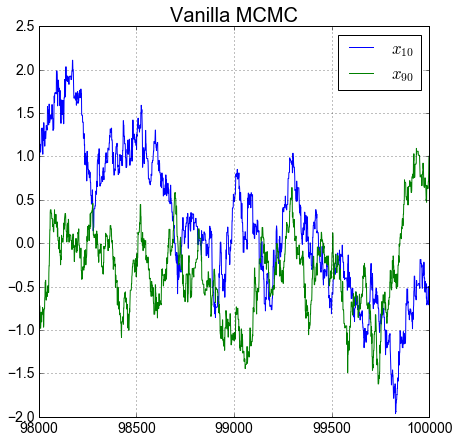

In [22]:
#Trace plot for the 10th and 90th components of x for demonstration
TP_N = 2000 #number of points to show in trace plot
N_van = X_van.shape[0]

plt.figure(figsize=(7, 7))
plt.plot(np.arange(N_van - TP_N, N_van), X_van[-TP_N:,9])
plt.plot(np.arange(N_van - TP_N, N_van), X_van[-TP_N:,89])
plt.grid(True)
plt.title('Vanilla MCMC', fontsize=20)
plt.legend([r'$x_{10}$', r'$x_{90}$'])

In [23]:
# sample inactive variables from prior and transform to original variables
P = 10 #Number of z samples for each y
X_AS = asamcmc.sample_original_variables(Y, P)

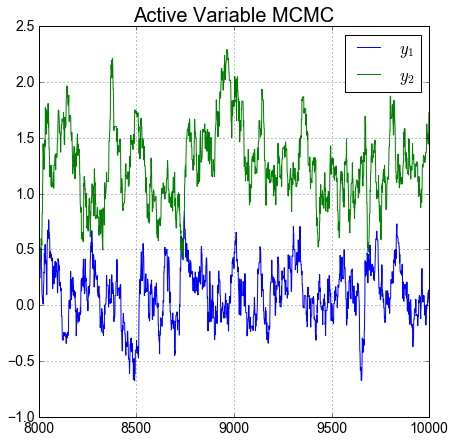

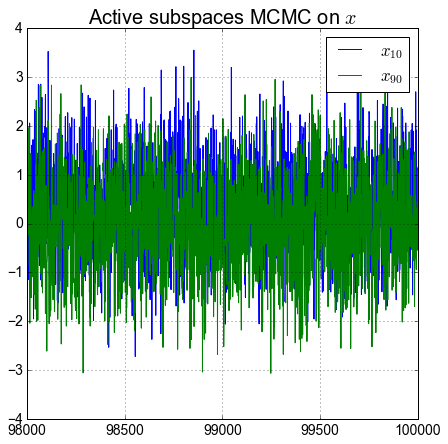

In [24]:
#Trace plot for the active variable
TP_N = 2000 #number of points to show in trace plot
N_AS = Y.shape[0]

plt.figure(figsize=(7, 7))
plt.plot(np.arange(N_AS - TP_N, N_AS), Y[-TP_N:,0])
plt.plot(np.arange(N_AS - TP_N, N_AS), Y[-TP_N:,1])
plt.grid(True)
plt.title('Active Variable MCMC', fontsize=20)
plt.legend([r'$y_1$', r'$y_2$'])

#Trace plot for the 10th and 90th components of x
TP_N = 2000 #number of points to show in trace plot
plt.figure(figsize=(7, 7))
plt.plot(np.arange(N_AS*P - TP_N, N_AS*P), X_AS[-TP_N:,9])
plt.plot(np.arange(N_AS*P - TP_N, N_AS*P), X_AS[-TP_N:,89])
plt.grid(True)
plt.title(r'Active subspaces MCMC on $x$', fontsize=20)
plt.legend([r'$x_{10}$', r'$x_{90}$'])

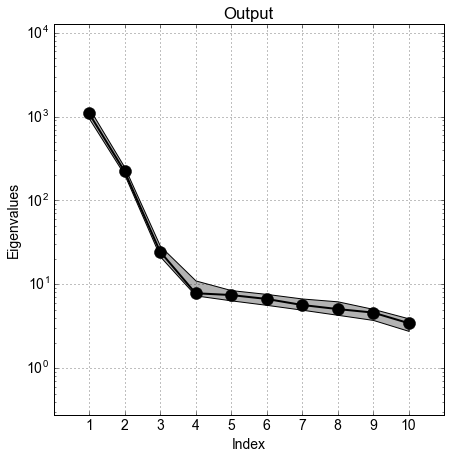

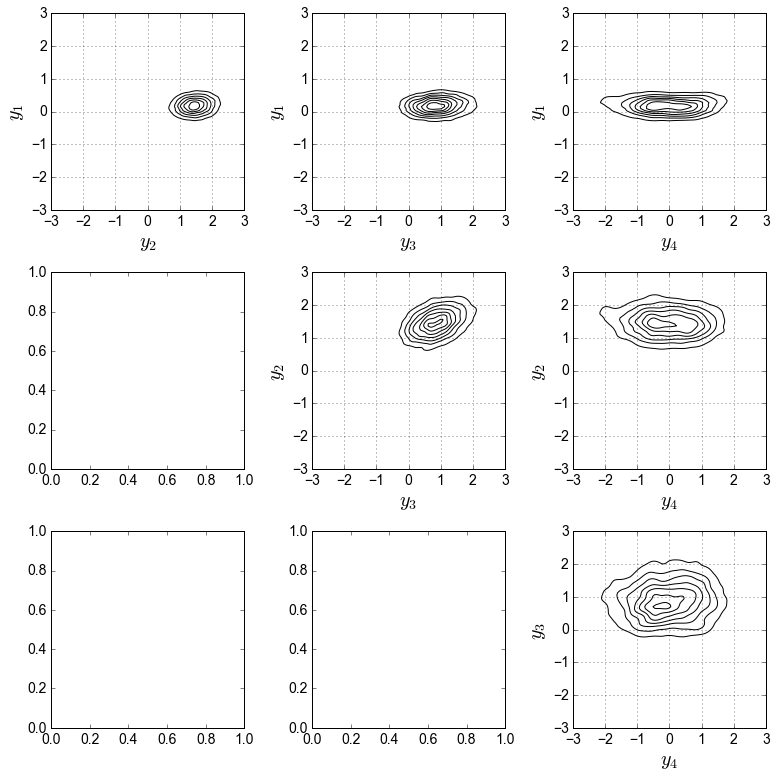

In [7]:
#We need to recompute the subspace since the simulated data used to generate the 100000-
#replicate chains is different from the data used for the 1000-replicate chains.
df = IO.loadmat('Gradient_Samples.mat')['Samples']
ss.compute(df=df, nboot=100); ss.partition(2)

#Plot subspace eigenvalues
ac.utils.plotters.eigenvalues(ss.eigenvals[:10, 0], e_br=ss.e_br[:10,:])

y = ss.eigenvecs.T.dot(X_van.T)

fig, axes = plt.subplots(3, 3, figsize=(11, 11)); axes = axes.reshape(9).squeeze()

xmin, xmax = -3, 3
ymin, ymax = -3, 3

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

plots = [0, 1, 2, 4, 5, 8]
masks = [[1, 0], [2, 0], [3, 0], [2, 1], [3, 1], [3, 2]]

for i in range(6):
    kernel = st.gaussian_kde(y[masks[i]])
    density = np.reshape(kernel(positions).T, xx.shape)
    
    axes[plots[i]].set_xlim(xmin, xmax)
    axes[plots[i]].set_ylim(ymin, ymax)
    cset = axes[plots[i]].contour(xx, yy, density, colors='k')
    axes[plots[i]].grid(True)
    axes[plots[i]].set_xlabel(r'$y_{}$'.format(masks[i][0]+1), fontsize=20)
    axes[plots[i]].set_ylabel(r'$y_{}$'.format(masks[i][1]+1), fontsize=20)
fig.tight_layout()

As we would expect, there is significant deviation from the prior in the first 2 components (the active variables) while the other components (the inactive variables) remain much closer to their priors.

We have shown for two forward models that reducing their dimensionality with active subspaces significantly improves the resulting Markov Chains. This methodology could potentially be used to increase computational efficiency in many Bayesian inverse problems.